# Introduction
This notebook is an introduction to the FEM calculation of the Boltzmann transport conductivity model. We will analyze a simple 2D free electron system.

Our goal is to calculate the conductivity tensor given by
$$\sigma_{ab} = \frac{2e^2}{(2\pi)^d\hbar} \int\mathop{d\mathbf{k}} \int\mathop{d\mathbf{k'}} \hat{v}_a(\mathbf{k}) A^{-1}(\mathbf{k},\mathbf{k'}) \hat{v}_b(\mathbf{k'}),$$
where $\hat{v}_a = v_a/\|\mathbf{v}\|$ and $A$ is the differential integral operator
$$A(\mathbf{k}, \mathbf{k'}) = \left(\frac{i\omega}{\|\mathbf{v}(\mathbf{k})\|} + \frac{1}{L(\mathbf{k})} - \frac{e\left(\hat{\mathbf{v}}(\mathbf{k})\times\mathbf{B}\right)}{\hbar}\cdot\frac{\partial}{\partial\mathbf{k}}\right)\delta(\mathbf{k}-\mathbf{k'}) - \frac{C(\mathbf{k},\mathbf{k'})}{\|\mathbf{v}(\mathbf{k})\|}.$$
Here, $1/L(\mathbf{k})$ is the inverse scattering length, defined as
$$\frac{1}{L(\mathbf{k})} = \frac{1}{\|\mathbf{v}(\mathbf{k})\|\tau(\mathbf{k})} = \int\mathop{d{\mathbf{k'}}}\frac{C(\mathbf{k'}, \mathbf{k})}{\|\mathbf{v}(\mathbf{k})\|}.$$
With the FEM method, we can expand the functions and operators in the basis $\{\psi_i(\mathbf{k})\}$ and approximate everything with them. For our current purpuses, we use piecewise linear functions that are only nonzero on the line segments connected to their corresponding elements on the Fermi surface and peak at those elements; If we call the line segment connecting the $i$ element to the $i+1$ element $I_i$ with length $l_i=|\mathbf{k}_i-\mathbf{k}_{i+1}|$, the basis function $\psi_i$ increases linearly from 0 to 1 over $I_{i-1}$ and decreases linearly from 1 to 0 over $I_i$. By using this basis, our calculation can be done in a linear algebra form (the details of the derivation are given in the accompanying document):
$$\sigma_{ab} = \frac{2e^2}{(2\pi)^d\hbar} \sum_{ij} (\hat{v}_a)_i (A^{-1})^{ij} (\hat{v}_b)_j$$
So, we should first calculate $v_i$ and $A_{ij}$, then do a matrix inversion (or solve a linear system), and finally apply an inner product.

# Fermi Surface
For free electrons, we have
$$E(\mathbf{k}) = \frac{\hbar k^2}{2m},$$
$$\mathbf{v}(\mathbf{k}) = \frac{1}{\hbar}\nabla_k E = \frac{\hbar\mathbf{k}}{m},$$
and Fermi surface is just a circle.

In [45]:
import numpy as np
from scipy.constants import e, hbar, m_e

kf = 1e10  # Fermi wave vector in m^-1
n = 100 # Number of points for approximating the Fermi surface
theta = np.linspace(0, 2 * np.pi, n)
kx, ky = kf * np.cos(theta), kf * np.sin(theta)
vx, vy = hbar * kx / m_e, hbar * ky / m_e
v = np.sqrt(vx**2 + vy**2)

## FEM elements: line segments

In [46]:
# Line segment lengths in k-space (unit m^-1)
dx = np.roll(kx, -1) - kx
dy = np.roll(ky, -1) - ky
lengths = np.sqrt(dx**2 + dy**2)

# Overlap Matrix $M_{ij}$
To "raise" and "lower" the indices (basically calculating integrals in our case), we would need the overlap matrix. Here, it is given by
$$M_{ij} = \frac{l_{i-1}+l_i}{3}\delta_{ij} + \frac{l_i}{6}\delta_{i+1,j} + \frac{l_j}{6}\delta_{i,j+1}.$$
The definition and the details of the calculation is given in the accompanying document.

In [47]:
import scipy as sp

indices = np.arange(len(lengths))
overlap_main = sp.sparse.csr_matrix(
    ((lengths+np.roll(lengths, 1)) / 3, (indices, indices)))
overlap_upper = sp.sparse.csr_matrix(
    (lengths / 6, (np.roll(indices, -1), indices)))
overlap_lower = sp.sparse.csr_matrix(
    (lengths / 6, (indices, np.roll(indices, -1))))
overlap_matrix = overlap_main + overlap_upper + overlap_lower

# Differential Operator $A_{ij}$
After discretizing, the differential operator is equal to
$$A_{ij} = \Gamma_{ij} - \frac{eB}{\hbar}\left(D_{\hat{\mathbf{v}}\times\hat{\mathbf{B}}}\right)_{ij}-S_{ij}.$$
The definitions and the details of the calculations are given in the accompanying document. In our current calculations, we set $S=0$.

We express $A_{ij}$ in diagonal ordered form to benefit from performance improvements.

## Out-Scattering Matrix $\Gamma_{ij}$
$$\Gamma_{ij} = \left(\frac{l_{i-1}+l_i}{4}\gamma^i + \frac{l_i}{12}\gamma^{i+1} + \frac{l_{i-1}}{12}\gamma^{i-1}\right)\delta_{ij} + \frac{l_i}{12}\left(\gamma^i+\gamma^{i+1}\right)\delta_{i+1,j} + \frac{l_j}{12}\left(\gamma^j+\gamma^{j+1}\right)\delta_{i,j+1}$$
and $\gamma^i$ is the inverse scattering length $(\tau\|\mathbf{v}\|)^{-1}$ for the $i$-th element.

In [48]:
# Scattering rate 1/tau in Hz
scattering_rate = 1e12
inverse_scattering_length = scattering_rate / v

# Gamma matrix
minor_diagonal_term = lengths / 12 * (
    inverse_scattering_length + np.roll(inverse_scattering_length, -1))
major_diagonal_term = (
    (np.roll(lengths, 1) + lengths) * inverse_scattering_length / 4
    + lengths * np.roll(inverse_scattering_length, -1) / 12
    + np.roll(lengths, 1) * np.roll(inverse_scattering_length, 1) / 12)
out_scattering_matrix = np.vstack(
    [minor_diagonal_term, major_diagonal_term, minor_diagonal_term])

## Derivative Matrix $\left(D_{\hat{\mathbf{v}}\times\hat{\mathbf{B}}}\right)_{ij}$
For our current case, we take the magnetic field to be perpendicular to the plane of motion, parallel to the $z$-axis. Therefore,
$$\left(D_{\hat{\mathbf{v}}\times\hat{\mathbf{B}}}\right)_{ij} = -\frac{1}{2}\delta_{i+1,j} + \frac{1}{2}\delta_{i,j+1}.$$

In [49]:
derivative_matrix = np.vstack([np.full_like(lengths, -0.5),
                               np.zeros_like(lengths),
                               np.full_like(lengths, 0.5)])

## Putting it together

In [50]:
def differential_operator(magnetic_field):
    return out_scattering_matrix - e*magnetic_field/hbar * derivative_matrix

# Solving the linear system
To calculate the $(A^{-1})^{ij}(v_b)_j$ part of the conductivity, we need to solve a linear system with $A_{ij}$ as the matrix and $(v_b)_j$ as the right-hand side. To do this, we first need an efficient method for inverting the the differential operator matrix. It is tridiagonal with extra terms in the corners, so we can use a banded matrix solver, plus the Sherman-Morrison formula. See the accompanying document for more details.

In [51]:
def solve_cyclic_tridiagonal_system(A, b):
    """
    Solve the cyclic tridiagonal system of equations Ax = b.

    # Parameters:
    A: a cyclic tridiagonal matrix in diagonal ordered form.
    b: the right-hand side vector.
    # Returns:
    x: the solution vector.
    """
    # A = B + uv^T where B is banded
    # building perturbation matrix uv^T
    u = np.zeros_like(b)
    free_factor = -A[1, 0] # arbitrary, but avoid division by zero
    A[1, 0] -= free_factor
    A[1, -1] -= A[0, 0] * A[2, -1] / free_factor
    u[0] = 1
    u[-1] = A[0, 0] / free_factor
    # For v, only the dot product is calculated, so only the first
    # and the last elements (the only nonzero elements) are kept
    v_1 = free_factor
    v_n = A[2, -1]

    # Tridiagonal matrix inversions
    # B^{-1}b
    banded_solution = sp.linalg.solve_banded((1, 1), A, b)
    # B^{-1}u
    rank_1_solution = sp.linalg.solve_banded((1, 1), A, u)

    # Dot products
    v_dot_banded_solution = v_1*banded_solution[0] + v_n*banded_solution[-1]
    v_dot_rank_1_solution = v_1*rank_1_solution[0] + v_n*rank_1_solution[-1]

    # A^{-1}b = B^{-1}b - (B^{-1}u) (v^T B^{-1}b) / (1 + v^T B^{-1}u)
    full_solution = (banded_solution - rank_1_solution
                     * (v_dot_banded_solution
                        / (1 + v_dot_rank_1_solution)))

    # Reset the matrix
    A[1, 0] += free_factor
    A[1, -1] += A[0, 0] * A[2, -1] / free_factor

    return full_solution

# Calculating the conductivity
Finally, putting everything together, we can calculate the conductivity.

In [52]:
def solve_conductivity(differential_operator, overlap_matrix,
                       a_velocity_ratio, b_velocity_ratio):
    # v_i = M_{ij} v^j
    a_velocity_ratio_covariant = overlap_matrix @ a_velocity_ratio
    b_velocity_ratio_covariant = overlap_matrix @ b_velocity_ratio

    linear_solution = solve_cyclic_tridiagonal_system(
        differential_operator, b_velocity_ratio_covariant)
    # e^2/\hbar (\hat{v}_a)_i (A^{-1})^{ij} (\hat{v}_b)_j
    return e**2 / (2 * np.pi**2 * hbar) * np.dot(
        a_velocity_ratio_covariant, linear_solution)

# Compare to the Drude formula
For a magnetic field in the $z$ direction, the Drude formula gives
$$\sigma_{xx} = \frac{ne^2\tau}{m}\frac{1}{1+(\omega_c\tau)^2}$$
$$\sigma_{xy} = -\frac{ne^2\tau}{m}\frac{\omega_c\tau}{1+(\omega_c\tau)^2}$$
where $n$ is the electron density and $\omega_c = \frac{eB}{m}$ is the cyclotron frequency. In 2D,
$$k_F=\sqrt{2\pi n},$$
Which we can use to compare the results from the Drude formula and the boltzmann conductivity FEM calculation.

In [53]:
def drude_conductivity(magnetic_field):
    omega_c = e * magnetic_field / m_e
    sigma_xx_drude = (e**2 * kf**2 / (2*np.pi*m_e) * scattering_rate
                      / (omega_c**2 + scattering_rate**2))
    sigma_xy_drude = -(e**2 * kf**2 / (2*np.pi*m_e) * omega_c
                       / (omega_c**2 + scattering_rate**2))
    return sigma_xx_drude, sigma_xy_drude

In [54]:
magnetic_fields = np.linspace(0, 30, 1000)  # in units of T
sigma_xx_drude, sigma_xy_drude = drude_conductivity(magnetic_fields)
sigma_xx_boltzmann = np.zeros_like(magnetic_fields)
sigma_xy_boltzmann = np.zeros_like(magnetic_fields)
for i, field in enumerate(magnetic_fields):
    differential_operator_matrix = differential_operator(field)
    sigma_xx_boltzmann[i] = solve_conductivity(
        differential_operator_matrix, overlap_matrix, vx/v, vx/v)
    sigma_xy_boltzmann[i] = solve_conductivity(
        differential_operator_matrix, overlap_matrix, vx/v, vy/v)

In [55]:
# plotting defaults
import matplotlib as mpl
mpl.rcdefaults()
mpl.rcParams['font.size'] = 24
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['pdf.fonttype'] = 3
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['lines.linewidth'] = 3

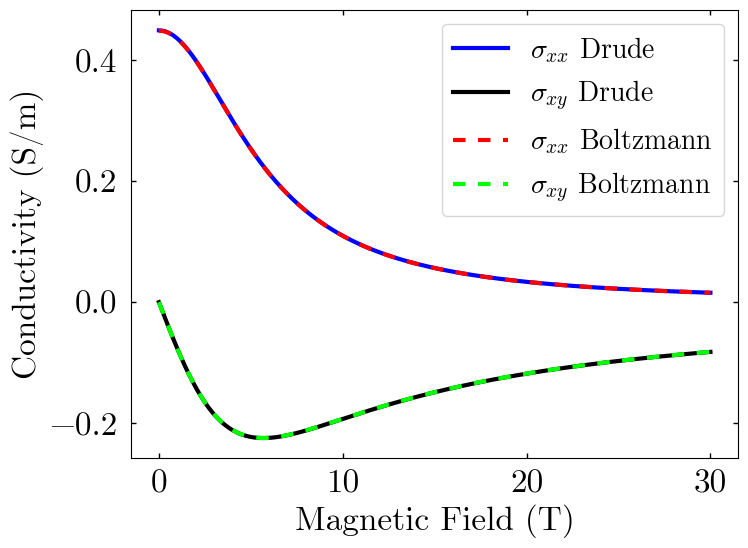

In [56]:
from matplotlib import pyplot as plt

plt.plot(magnetic_fields, sigma_xx_drude,
         label=fr"$\sigma_{{xx}}$ Drude", color='blue')
plt.plot(magnetic_fields, sigma_xy_drude,
         label=fr"$\sigma_{{xy}}$ Drude", color='black')
plt.plot(magnetic_fields, sigma_xx_boltzmann, linestyle=(0, (3, 3)),
         color='red', label=fr"$\sigma_{{xx}}$ Boltzmann",)
plt.plot(magnetic_fields, sigma_xy_boltzmann, linestyle=(0, (3, 3)),
         color='lime', label=fr"$\sigma_{{xy}}$ Boltzmann",)

plt.xlabel("Magnetic Field (T)")
plt.ylabel("Conductivity (S/m)")
plt.tick_params(axis='x', which='major', pad=8)
plt.tick_params(axis='y', which='major', pad=10)
plt.legend()
plt.tight_layout()
plt.show()